In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import timm  # TimeSformer model
from transformers import TimesformerModel, TimesformerConfig
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else ("cpu")
print(device)

cuda


In [3]:
from PIL import Image
class DeepFakeVideoDataset(Dataset):
    def __init__(self, video_dir, transform=None, frames_per_video=16):
        self.video_dir = video_dir
        self.transform = transform
        self.frames_per_video = frames_per_video
        self.videos, self.labels = self.load_videos_labels()  # Modify as needed

    def __getitem__(self, idx):
        video_path = self.videos[idx]
        label = self.labels[idx]

        # Extract frames
        frames = self.extract_frames(video_path)

        # Apply the transformation to each frame
        if self.transform:
            frames = [self.transform(frame) for frame in frames]

        # Stack frames into a tensor (keep the channels correct: [frames, 3, H, W])
        frames = torch.stack(frames, dim=0)  # Shape: [frames_per_video, 3, H, W]
        
        return frames, label

    def extract_frames(self, video_path):
        # Your frame extraction logic
        # Make sure this returns frames as individual images (not stacked yet)
        frames = []
        video = cv2.VideoCapture(video_path)
        success, frame = video.read()
        while success and len(frames) < self.frames_per_video:
            # Convert frame (OpenCV uses BGR by default)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame)  # Convert to PIL Image
            frames.append(frame)
            success, frame = video.read()
        video.release()

        # If not enough frames, duplicate the last one
        while len(frames) < self.frames_per_video:
            frames.append(frames[-1])

        return frames

    def __len__(self):
        return len(self.videos)

    def load_videos_labels(self):
        videos = []
        labels = []
        # Assuming class folders inside video_dir, e.g., video_dir/real, video_dir/fake
        for class_label, class_name in enumerate(os.listdir(self.video_dir)):
            class_folder = os.path.join(self.video_dir, class_name)
            if os.path.isdir(class_folder):
                for video_name in os.listdir(class_folder):
                    video_path = os.path.join(class_folder, video_name)
                    if video_path.endswith(('.mp4', '.avi')):  # Check for video formats
                        videos.append(video_path)
                        labels.append(class_label)  # real = 0, fake = 1 (based on folder order)

        return videos, labels
        pass

In [4]:
# Model creation using TimeSformer
class DeepFakeTimeSformer(nn.Module):
    def __init__(self):
        super(DeepFakeTimeSformer, self).__init__()
        self.model = TimesformerModel.from_pretrained('facebook/timesformer-base-finetuned-k400')
        self.classifier = nn.Linear(self.model.config.hidden_size, 2)  # Single output for binary classification

    def forward(self, pixel_values):
        outputs = self.model(pixel_values=pixel_values)
        # Use the mean of the hidden states for classification
        logits = outputs.last_hidden_state.mean(dim=1)  # Shape: [batch_size, hidden_size]
        return self.classifier(logits)  # Shape: [batch_size, 1]

In [5]:
# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    train_acc_history = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            # Backward pass + optimization
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            running_loss += loss.item()

        train_acc = correct / total
        train_acc_history.append(train_acc)
    
    return train_acc_history

In [6]:
# Validation function
def validate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Store predictions and labels for AUC calculation
            all_preds.append(outputs.cpu())
            all_labels.append(labels.cpu())

            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    # Calculate accuracy and AUC
    accuracy = correct / total
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    auc = roc_auc_score(all_labels.numpy(), all_preds.softmax(dim=1)[:, 1].numpy())
    
    return accuracy, auc

In [7]:
# Plotting the training accuracy
def plot_training_acc(train_acc_history):
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy over Epochs')
    plt.legend()
    plt.show()

In [8]:
# Define transforms (resize and normalize the frames)
batch_size = 8
import os
#data_transforms = transforms.Compose([
    #transforms.ToPILImage(),
   # transforms.Resize((224, 224)),
    #transforms.ToTensor(),
   # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization for pre-trained models
#])

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the frames
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization for pre-trained models
])

# Load datasets using the custom dataset class
train_dataset = DeepFakeVideoDataset(video_dir='Downloads/Dataset', transform=data_transforms)
test_dataset = DeepFakeVideoDataset(video_dir='Downloads/Dataset', transform=data_transforms)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Epoch 1/5
Checkpoint saved at epoch 1
Epoch 1 - Test Accuracy: 0.8000, AUC: 0.7190

Epoch 2/5
Checkpoint saved at epoch 2
Epoch 2 - Test Accuracy: 0.8220, AUC: 0.8880

Epoch 3/5
Checkpoint saved at epoch 3
Epoch 3 - Test Accuracy: 0.8230, AUC: 0.9198

Epoch 4/5
Checkpoint saved at epoch 4
Epoch 4 - Test Accuracy: 0.8570, AUC: 0.9344

Epoch 5/5
Checkpoint saved at epoch 5
Epoch 5 - Test Accuracy: 0.8560, AUC: 0.9373


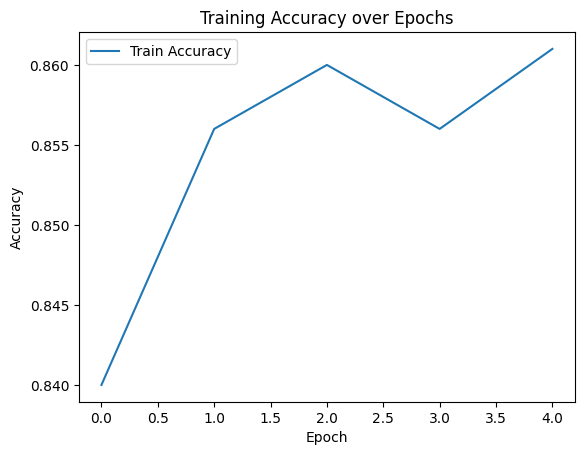

In [10]:
import cv2

# Ensure to define device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def save_checkpoint(epoch, model, optimizer, filepath='model_checkpoint.pth'):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(state, filepath)
    print(f"Checkpoint saved at epoch {epoch}")

def load_checkpoint(filepath='model_checkpoint.pth'):
    checkpoint = torch.load(filepath)
    model = DeepFakeTimeSformer().to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    print(f"Checkpoint loaded, resuming from epoch {epoch}")
    return model, optimizer, epoch

def main(resume=False):
    # Hyperparameters
    num_epochs = 5  # Reduced for faster experimentation
    learning_rate = 1e-4
    batch_size = 8
    frames_per_video = 16

    # Load dataset using the custom dataset class
    train_dataset = DeepFakeVideoDataset(video_dir='Downloads/Dataset', transform=data_transforms, frames_per_video=frames_per_video)
    test_dataset = DeepFakeVideoDataset(video_dir='Downloads/Dataset', transform=data_transforms, frames_per_video=frames_per_video)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

    # Model initialization
    if resume and os.path.exists('model_checkpoint.pth'):
        model, optimizer, start_epoch = load_checkpoint()
    else:
        model = DeepFakeTimeSformer().to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        start_epoch = 0

    criterion = nn.CrossEntropyLoss()

    # Training loop with early stopping
    best_acc = 0
    patience = 2  # Early stopping patience
    patience_counter = 0

    for epoch in range(start_epoch, num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        model.train()
        train_acc = train_model(model, train_loader, criterion, optimizer, num_epochs)

        # Save checkpoint after each epoch
        save_checkpoint(epoch + 1, model, optimizer)

        # Validate the model and check for early stopping
        test_acc, test_auc = validate_model(model, test_loader)
        print(f'Epoch {epoch + 1} - Test Accuracy: {test_acc:.4f}, AUC: {test_auc:.4f}')

        # Early stopping
        if test_acc > best_acc:
            best_acc = test_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping activated.")
                break

    # Plot training accuracy
    plot_training_acc(train_acc)

if __name__ == '__main__':
    main(resume=False)

In [ ]:
def predict_video_authenticity(model, video_path, device):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0

    # Read and preprocess frames
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),  # Example size, adjust to your model's input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    while frame_count < 16:  # Assume the model takes 16 frames as input
        ret, frame = cap.read()
        if not ret:
            break
        frame = transform(frame)
        frames.append(frame)
        frame_count += 1

    cap.release()

    if len(frames) < 16:
        print("Not enough frames in the video to make a prediction.")
        return None

    # Stack frames and add batch dimension
    frames_tensor = torch.stack(frames).unsqueeze(0).to(device)  # Shape: (1, 16, 3, 224, 224)

    # Predict using the model
    model.eval()
    with torch.no_grad():
        output = model(frames_tensor)
        probabilities = torch.softmax(output, dim=1)
        real_prob = probabilities[0][0].item()
        fake_prob = probabilities[0][1].item()

    print(f"Real Probability: {real_prob:.4f}, Fake Probability: {fake_prob:.4f}")
    return real_prob, fake_prob

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepFakeTimeSformer().to(device)  # Replace with your model loading function
video_path = input("Enter the path to the video file: ")
predict_video_authenticity(model, video_path, device)


In [ ]:
# Save the model's state dictionary after training
torch.save(model.state_dict(), 'deepfake_model.pth')
print("Model saved successfully!")
